### Install & Import Packages

**Install Patoolib for unzipping Dataset**

In [1]:
!pip install patool
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import All Need Libraries**

In [2]:
import cv2
import os
from random import choice
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist, equalize_adapthist, histogram
import patoolib
from sklearn.manifold import TSNE
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, Xception, vgg16, resnet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix,\
 classification_report, plot_confusion_matrix, roc_curve, precision_score, recall_score

###Auxiliary  Functions

**Early Stopping To Prevent Overfitting**
****
This Function Stops Training if ```val_loss``` not efficiently decreases after 5 Epochs

In [3]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

**Optimizer For All Model**

**Using 0.0001 For Learning Rate**

In [4]:
optimizer = Adam(learning_rate=0.0001)

**A Function That Reads An Image And Return it**

In [5]:
def ShowImage(*, img, title):
    plt.title(title)
    plt.imshow(img)
    plt.show() 

**A Function Plots Accuracy of Given Model History as ```hist```**

In [6]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Preparing Data
****
1.  **Connect To Google Drive**
2.  **Unzipping Data**

**Mounting Google Drive**

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


**Unzipping Dataset**

In [8]:
patoolib.extract_archive('/content/drive/MyDrive/Skin Cancer-Malignant-Benign.zip')

patool: Extracting /content/drive/MyDrive/Skin Cancer-Malignant-Benign.zip ...
patool: running /usr/bin/7z x -o./Unpack_yrslmml1 -- "/content/drive/MyDrive/Skin Cancer-Malignant-Benign.zip"
patool: ... /content/drive/MyDrive/Skin Cancer-Malignant-Benign.zip extracted to `Skin Cancer-Malignant-Benign' (multiple files in root).


'Skin Cancer-Malignant-Benign'

### Preprocessing
****
1.   **Resize Images into 224 × 224**
2.   **Normalization**
3.   **Apply Gaussian blurring To Remove Noise**
4.   **Apply Contrast Limited Adaptive Histogram Equalization
(CLAHE)**



**Data Pathes**

In [9]:
folder_benign_train = '/content/Skin Cancer-Malignant-Benign/train/benign'
folder_malignant_train = '/content/Skin Cancer-Malignant-Benign/train/malignant'

folder_benign_test = '/content/Skin Cancer-Malignant-Benign/test/benign'
folder_malignant_test = '/content/Skin Cancer-Malignant-Benign/test/malignant'

**Function For Reading an Image Using open cv**



In [10]:
def ReadImage(*, Path):
    src = cv2.imread(Path)
    return src

**Function For Resizing an Image Using open cv**

In [11]:
def ResizeImage(*, img, width, height):
    resized = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)
    return resized

**Function For Normalize an Image Using open cv**

In [12]:
def NormalizeImage(*, img):
    # norm_image = (img - np.min(img)) / (np.max(img) - np.min(img))
    norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm_image

**Function For Apply Gaussian Blur on an Image Using open cv**

In [13]:
def GaussianBlurImage(*, img, kernel):
    GBlur = cv2.GaussianBlur(img, kernel, cv2.BORDER_DEFAULT)
    return GBlur

**Function for Drawing Bar Histogram of an Image**

In [14]:
def DrawHistogram(*, img, range, title):
    plt.hist(img.flat, bins=100, range=range)
    plt.title(title)
    plt.show()

**Function For Apply CLAHE(Contrast Limited Adaptive Histogram Equalization) on an Image Using Scikit Image**


In [15]:
def CLAHE(*, img, cliplimit, kernel):
    cl_img = equalize_adapthist(img[:,:,0], clip_limit=cliplimit, kernel_size=kernel)
    return np.dstack((cl_img, img[:, :, 1], img[:, :, 2]))

**Create Needed Directories**
****
**if Scaled Data has been Already in Your Drive It's No Need To Run This Cell**

In [16]:
ScaledDataRoot = '/content/ScaledData/'

ScaledDataTrain = '/content/ScaledData/train'
ScaledDataTest = '/content/ScaledData/test'

ScaledDataTrainBenign = '/content/ScaledData/train/benign'
ScaledDataTrainMalignant = '/content/ScaledData/train/malignant'

ScaledDataTestBenign = '/content/ScaledData/test/benign'
ScaledDataTestMalignant = '/content/ScaledData/test/malignant'

if os.path.isdir(ScaledDataRoot)== False:
    os.mkdir(ScaledDataRoot)

    os.mkdir(ScaledDataTrain)
    os.mkdir(ScaledDataTest)

    os.mkdir(ScaledDataTrainBenign)
    os.mkdir(ScaledDataTrainMalignant)

    os.mkdir(ScaledDataTestBenign)
    os.mkdir(ScaledDataTestMalignant)

**Function For Apply Preprocessing on Images in ```DataPath``` Folder And Write Them on ```ScaledPath``` Folder**

In [17]:
def PreprocessImages(*, DataPath, ScaledPath, ImagesWidth, ImagesHeight):
  print(f'Preprocess on Folder {DataPath} ... :', end=' ')
  for image in os.listdir(DataPath):
      try:
        src = ReadImage(Path=os.path.join(DataPath, image))
        resized = ResizeImage(img=src, width=ImagesWidth, height=ImagesHeight)
        norm_image = NormalizeImage(img=resized)
        GBlur = GaussianBlurImage(img=norm_image, kernel=(5,5))
        cl_img = CLAHE(img=GBlur, cliplimit=2.0, kernel=(8,8))
        plt.imsave(f'{ScaledPath}/{image}', cl_img) 
      except Exception as e:
        print(e)
        print(f'There is a Problem in Processing image {os.path.join(DataPath, image)}')
  print('Done!')     

**Apply Preprocessing on All Train And Test Images**
****
**if Scaled Data has been Already in Your Drive It's No Need To Run This Cell**

In [18]:
PreprocessImages(DataPath=folder_benign_train, ScaledPath=ScaledDataTrainBenign, ImagesWidth=224, ImagesHeight=224)

PreprocessImages(DataPath=folder_malignant_train, ScaledPath=ScaledDataTrainMalignant, ImagesWidth=224, ImagesHeight=224)

PreprocessImages(DataPath=folder_benign_test, ScaledPath=ScaledDataTestBenign, ImagesWidth=224, ImagesHeight=224)

PreprocessImages(DataPath=folder_malignant_test, ScaledPath=ScaledDataTestMalignant, ImagesWidth=224, ImagesHeight=224)

Preprocess on Folder /content/Skin Cancer-Malignant-Benign/train/benign ... : Done!
Preprocess on Folder /content/Skin Cancer-Malignant-Benign/train/malignant ... : Done!
Preprocess on Folder /content/Skin Cancer-Malignant-Benign/test/benign ... : Done!
Preprocess on Folder /content/Skin Cancer-Malignant-Benign/test/malignant ... : Done!


**Sample Plot**

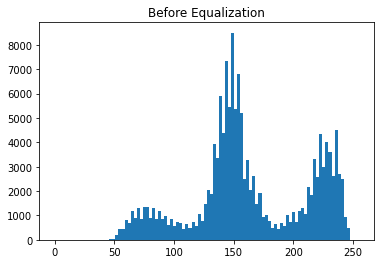

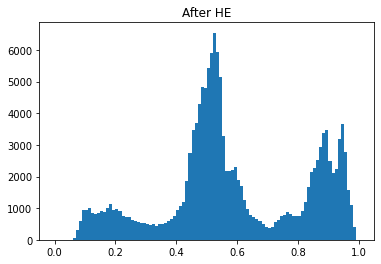

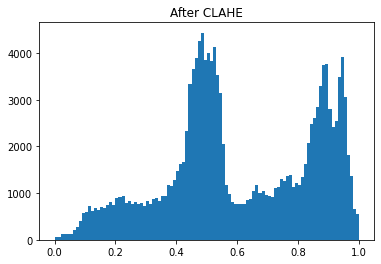

In [19]:
image = choice(os.listdir(folder_benign_train))
src = ReadImage(Path=os.path.join(folder_benign_train, image))
DrawHistogram(range=(0,255), img=src, title='Before Equalization')
resized = ResizeImage(img=src, width=224, height=224)
norm_image = NormalizeImage(img=resized)
GBlur = GaussianBlurImage(img=norm_image, kernel=(5,5))
DrawHistogram(range=(0,1), img=GBlur, title='After HE')
cl_img = CLAHE(img=GBlur, cliplimit=2.0, kernel=(8,8))
DrawHistogram(range=(0,1), img=cl_img, title='After CLAHE')

**Copy Scaled Data Folder In Your Drive**
****
**if Scaled Data has been Already in Your Drive It's No Need To Run This Cell**

In [ ]:
!cp -r "/content/ScaledData" "/content/drive/MyDrive"

**Preprocess on a Given Image ```Path```**

In [20]:
def PreprocessSingleImage(*, Path, ImagesWidth, ImagesHeight):
  src = ReadImage(Path=Path)
  resized = ResizeImage(img=src, width=ImagesWidth, height=ImagesHeight)
  norm_image = NormalizeImage(img=resized)
  GBlur = GaussianBlurImage(img=norm_image, kernel=(5,5))
  cl_img = CLAHE(img=GBlur, cliplimit=2.0, kernel=(8,8))
  return cl_img

**T-SNE**

In [21]:
Data = []
label = []

for image in os.listdir(folder_benign_train):
    src = ReadImage(Path=os.path.join(folder_benign_train, image))
    Data.append(src.flatten())
    label.append(0)

for image in os.listdir(folder_malignant_train):
    src = ReadImage(Path=os.path.join(folder_malignant_train, image))
    Data.append(src.flatten())   
    label.append(1) 

X = np.array(Data)
y = np.array(label)


In [22]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=90.0,).fit_transform(X)

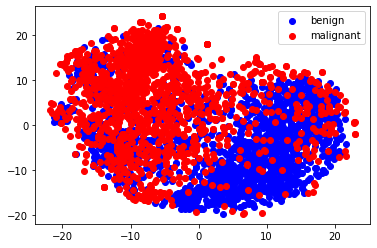

In [23]:
plt.scatter([X_embedded[i][0] for i in range(len(X_embedded)) if label[i]==0], [X_embedded[i][1] for i in range(len(X_embedded)) if label[i]==0],
            color='blue', label='benign')  
plt.scatter([X_embedded[i][0] for i in range(len(X_embedded)) if label[i]==1], [X_embedded[i][1] for i in range(len(X_embedded)) if label[i]==1],
            color='red', label='malignant')  

plt.legend()
plt.show()  

### Preprocessed Data Loading

**Data Generator For Training And Test Data**
****
**Data Augmentation When Loading Data**

**Horizontal & Vertical Flip**

**Fill Mode : Nearest**

In [24]:
train_gen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

test_gen = ImageDataGenerator()

**Loading Scaled Data**
****
**Try To Load From Drive, Otherwise Loads From Local Storage!**

In [25]:
try:
  train_ds = train_gen.flow_from_directory('/content/drive/MyDrive/ScaledData/train',target_size=(224, 224),
                                           batch_size=16, shuffle=True)
  test_ds = test_gen.flow_from_directory('/content/drive/MyDrive/ScaledData/test',target_size=(224, 224),
                                         batch_size=16, shuffle=True)
  print('Dataset Has Already in Your Drive!')
except:
  train_ds = train_gen.flow_from_directory('/content/ScaledData/train',target_size=(224, 224),
                                           batch_size=16, shuffle=True)
  test_ds = test_gen.flow_from_directory('/content/ScaledData/test',target_size=(224, 224),
                                         batch_size=16, shuffle=True)
  print('Dataset Has not Already in Your Drive And Loaded From Local Storage!')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Dataset Has Already in Your Drive!


### Define & Train EfficientNet B0

**Try To Load Saved ```EfficientNetB0``` Model**
****
**If You See ```Load Complete! No Need To Train EfficientNetB0.``` Message Means The Efficient B0 Model Loaded Successfully and No Need To Run The Rest of This Section's Cells!**

**And If You See ```Load Failed! You Should Train EfficientNetB0.``` Message Means Cannot be Load Because of Missing Model Files And You Should Define And Train Model. For This You Should Run Rest of This Section's Cells**

In [ ]:
try:
  ModelEfficientNetB0 = load_model('/content/drive/MyDrive/EfficientNetB0')
  print('Load Complete! No Need To Train EfficientNetB0.')
except:
  print('Load Failed! You Should Train EfficientNetB0.')  

Load Complete! No Need To Train EfficientNetB0.


**Graph The EfficientNetB0 Model**

**Define Feature Extractor Model of ```EfficientNetB0``` Without Last Layer and Also Add The Following Layers:**

1. ```Input``` Layer with Shape (224, 224, 3) at The First Of Model
2. ```GlobalAveragePooling2D``` Layer at The End Of Model
3. ```BatchNormalization``` Layer After ```GlobalAveragePooling2D```
4. A ```Dense``` Layer with Softmax Activation Function as Last Layer of Model.

**We Set ```trainable``` Feature To Set All Layers Weight Updatable**

In [27]:
inputs = Input(shape=(224, 224, 3))
ModelEfficientNetB0 = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

x = GlobalAveragePooling2D(name="avg_pool")(ModelEfficientNetB0.output)
x = BatchNormalization()(x)

outputs = Dense(2, activation="sigmoid", name="pred")(x)
ModelEfficientNetB0.trainable = True

16705208/16705208 [==============================] - 0s 0us/step


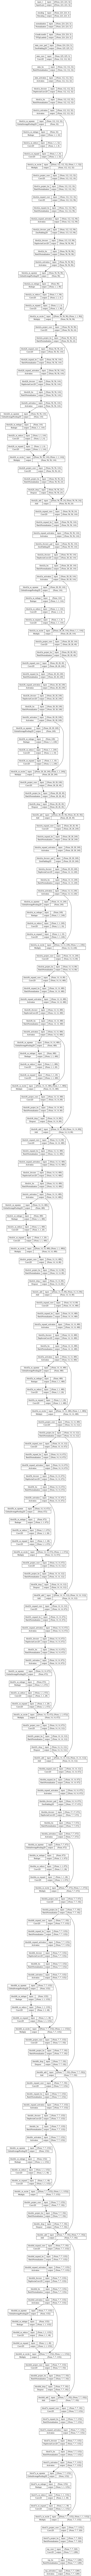

In [28]:
plot_model(ModelEfficientNetB0, show_shapes=True, to_file='ModelEfficientNetB0.png')

**Compile Model**
1.  **Using Adam Optimizer**
2.  **Using ```learning_rate=0.0001```**
3.  **Using ```binary_crossentropy``` as Loss Function**

In [29]:
ModelEfficientNetB0 = Model(inputs, outputs, name="EfficientNet-B0")
ModelEfficientNetB0.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

**Train Model**
1.  **30 Epochs**
2.  **Batch Size of 16** 

Epoch 1/30
165/165 - 47s - loss: 0.4974 - accuracy: 0.7804 - val_loss: 0.5520 - val_accuracy: 0.7470 - 47s/epoch - 286ms/step
Epoch 2/30
165/165 - 27s - loss: 0.3640 - accuracy: 0.8457 - val_loss: 0.3612 - val_accuracy: 0.8394 - 27s/epoch - 163ms/step
Epoch 3/30
165/165 - 27s - loss: 0.3115 - accuracy: 0.8707 - val_loss: 0.3470 - val_accuracy: 0.8273 - 27s/epoch - 165ms/step
Epoch 4/30
165/165 - 28s - loss: 0.2640 - accuracy: 0.8912 - val_loss: 0.3242 - val_accuracy: 0.8530 - 28s/epoch - 167ms/step
Epoch 5/30
165/165 - 28s - loss: 0.2375 - accuracy: 0.9082 - val_loss: 0.3310 - val_accuracy: 0.8591 - 28s/epoch - 168ms/step
Epoch 6/30
165/165 - 28s - loss: 0.2137 - accuracy: 0.9147 - val_loss: 0.3260 - val_accuracy: 0.8530 - 28s/epoch - 167ms/step
Epoch 7/30
165/165 - 28s - loss: 0.1773 - accuracy: 0.9310 - val_loss: 0.3831 - val_accuracy: 0.8470 - 28s/epoch - 168ms/step
Epoch 8/30
165/165 - 28s - loss: 0.1590 - accuracy: 0.9378 - val_loss: 0.3683 - val_accuracy: 0.8545 - 28s/epoch - 171

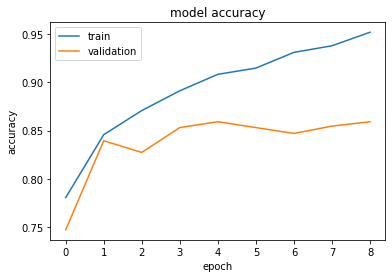

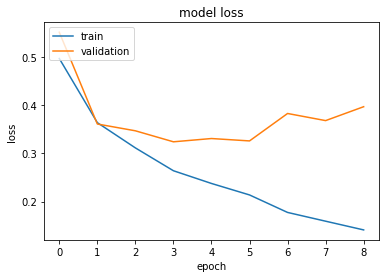

In [30]:
hist = ModelEfficientNetB0.fit(train_ds, epochs=30, validation_data=test_ds, verbose=2, batch_size=16, callbacks=[early_stopping])
plot_hist(hist)

**Saving Model**

In [31]:
ModelEfficientNetB0.save('EfficientNetB0')

**Copy Model Folder in Your Drive**

In [ ]:
!cp -r "/content/EfficientNetB0" "/content/drive/MyDrive"

**Evaluate The Model On Training & Test Data Set**

In [32]:
LossEfficientNetB0_train, AccEfficientNetB0_train = ModelEfficientNetB0.evaluate(train_ds)
LossEfficientNetB0_test, AccEfficientNetB0_test = ModelEfficientNetB0.evaluate(test_ds)

print(f'Accuracy EfficientNetB0 on Training Data: {AccEfficientNetB0_train}')
print(f'Accuracy EfficientNetB0 on Test Data: {AccEfficientNetB0_test}')

42/42 [==============================] - 2s 37ms/step - loss: 0.3971 - accuracy: 0.8591
Accuracy EfficientNetB0 on Training Data: 0.9863481521606445
Accuracy EfficientNetB0 on Test Data: 0.8590909242630005


### Define & Train Densnet121

**Try To Load Saved ```DenseNet121``` Model**
****
**If You See ```Load Complete! No Need To Train DenseNet121.``` Message Means The DenseNet121 Model Loaded Successfully and No Need To Run The Rest of This Section's Cells!**

**And If You See ```Load Failed! You Should Train DenseNet121.``` Message Means Cannot be Load Because of Missing Model Files And You Should Define And Train Model. For This You Should Run Rest of This Section's Cells**

In [ ]:
try:
  ModelDenseNet121 = load_model('/content/drive/MyDrive/DenseNet121')
  print('Load Complete! No Need To Train DenseNet121.')
except:
  print('Load Failed! You Should Train DenseNet121.') 

Load Complete! No Need To Train DenseNet121.


**Graph The DenseNet121 Model**

**Define Feature Extractor Model of ```DenseNet121``` Without Last Layer and Input Shape of (224, 224, 3). Also Add The Following Layers:**

1. ```Flatten``` Layer at The End Of Model
2. ```BatchNormalization``` Layer After ```Flatten```
3. A ```Dense``` Layer with Softmax Activation Function as Last Layer of Model.

**We Set ```trainable``` Feature To Set All Layers Weight Updatable**

In [33]:
ModelDenseNet121 = DenseNet121(include_top=False, input_shape=(224,224,3), weights="imagenet")
x = Flatten()(ModelDenseNet121.output)

outputDenseNet121 = Dense(2, activation='sigmoid')(x)

ModelDenseNet121.trainable = True

29084464/29084464 [==============================] - 0s 0us/step


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.693966 to fit



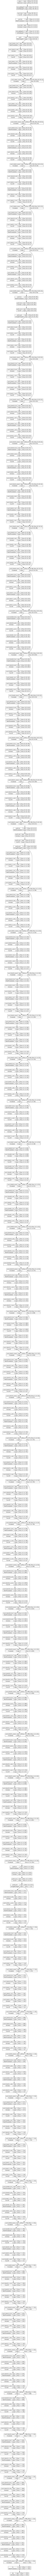

In [34]:
plot_model(ModelDenseNet121, show_shapes=True, to_file='ModelDenseNet121.png')

**Compile Model**
1.  **Using Adam Optimizer**
2.  **Using ```learning_rate=0.0001```**
3.  **Using ```binary_crossentropy``` as Loss Function**

In [35]:
ModelDenseNet121 = Model(inputs=ModelDenseNet121.input, outputs=outputDenseNet121, name="DenseNet-121")
ModelDenseNet121.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

**Train Model**
1.  **30 Epochs**
2.  **Batch Size of 16** 

Epoch 1/30
165/165 - 50s - loss: 0.5192 - accuracy: 0.7922 - val_loss: 0.6394 - val_accuracy: 0.7682 - 50s/epoch - 301ms/step
Epoch 2/30
165/165 - 31s - loss: 0.3711 - accuracy: 0.8377 - val_loss: 2.4091 - val_accuracy: 0.6652 - 31s/epoch - 191ms/step
Epoch 3/30
165/165 - 32s - loss: 0.3410 - accuracy: 0.8487 - val_loss: 0.5729 - val_accuracy: 0.8439 - 32s/epoch - 194ms/step
Epoch 4/30
165/165 - 32s - loss: 0.2820 - accuracy: 0.8707 - val_loss: 0.4053 - val_accuracy: 0.8076 - 32s/epoch - 195ms/step
Epoch 5/30
165/165 - 32s - loss: 0.3200 - accuracy: 0.8722 - val_loss: 0.4011 - val_accuracy: 0.8242 - 32s/epoch - 193ms/step
Epoch 6/30
165/165 - 32s - loss: 0.3303 - accuracy: 0.8665 - val_loss: 0.4246 - val_accuracy: 0.8152 - 32s/epoch - 195ms/step
Epoch 7/30
165/165 - 32s - loss: 0.3099 - accuracy: 0.8805 - val_loss: 0.3323 - val_accuracy: 0.8424 - 32s/epoch - 195ms/step
Epoch 8/30
165/165 - 32s - loss: 0.2272 - accuracy: 0.9060 - val_loss: 0.2918 - val_accuracy: 0.8727 - 32s/epoch - 196

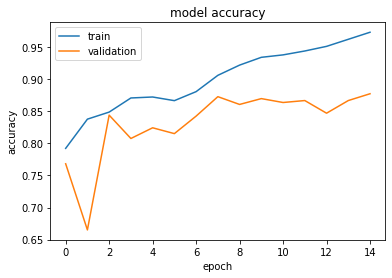

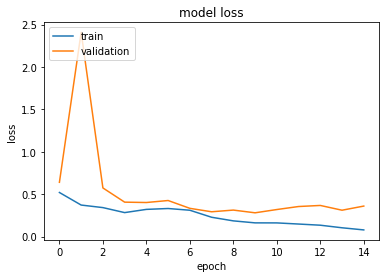

In [36]:
hist = ModelDenseNet121.fit(train_ds, epochs=30, validation_data=test_ds, verbose=2, batch_size=16, callbacks=[early_stopping])
plot_hist(hist)

**Saving Model**

In [37]:
ModelDenseNet121.save('DenseNet121')

**Copy Model Folder in Your Drive**

In [ ]:
!cp -r "/content/DenseNet121" "/content/drive/MyDrive"

**Evaluate The Model On Training & Test Data Set**

In [38]:
LossDenseNet121_train, AccDenseNet121_train = ModelDenseNet121.evaluate(train_ds)
LossDenseNet121_test, AccDenseNet121_test = ModelDenseNet121.evaluate(test_ds)

print(f'Accuracy DenseNet121 on Training Data: {AccDenseNet121_train}')
print(f'Accuracy DenseNet121 on Test Data: {AccDenseNet121_test}')

42/42 [==============================] - 2s 52ms/step - loss: 0.3590 - accuracy: 0.8773
Accuracy DenseNet121 on Training Data: 0.9745923280715942
Accuracy DenseNet121 on Test Data: 0.8772727251052856


### Define & Train Xception

**Try To Load Saved ```Xception``` Model**
****
**If You See ```Load Complete! No Need To Train Xception.``` Message Means The Xception Model Loaded Successfully and No Need To Run The Rest of This Section's Cells!**

**And If You See ```Load Failed! You Should Train Xception.``` Message Means Cannot be Load Because of Missing Model Files And You Should Define And Train Model. For This You Should Run Rest of This Section's Cells**

In [ ]:
try:
  ModelXception = load_model('/content/drive/MyDrive/Xception')
  print('Load Complete! No Need To Train Xception.')
except:
  print('Load Failed! You Should Train Xception.')

Load Complete! No Need To Train Xception.


**Graph The Xception Model**

**Define Feature Extractor Model of ```DenseNet121``` Without Last Layer and Input Shape of (224, 224, 3). Also Add The Following Layers:**

1. ```Flatten``` Layer at The End Of Model
2. ```BatchNormalization``` Layer After ```Flatten```
3. A ```Dense``` Layer with Softmax Activation Function as Last Layer of Model.

**We Set ```trainable``` Feature To Set All Layers Weight Updatable**

In [39]:
ModelXception = Xception(include_top=False, input_shape=(224,224,3), weights="imagenet")
x = Flatten()(ModelXception.output)
outputXception = Dense(2, activation='sigmoid')(x)

ModelXception.trainable = True

83683744/83683744 [==============================] - 3s 0us/step


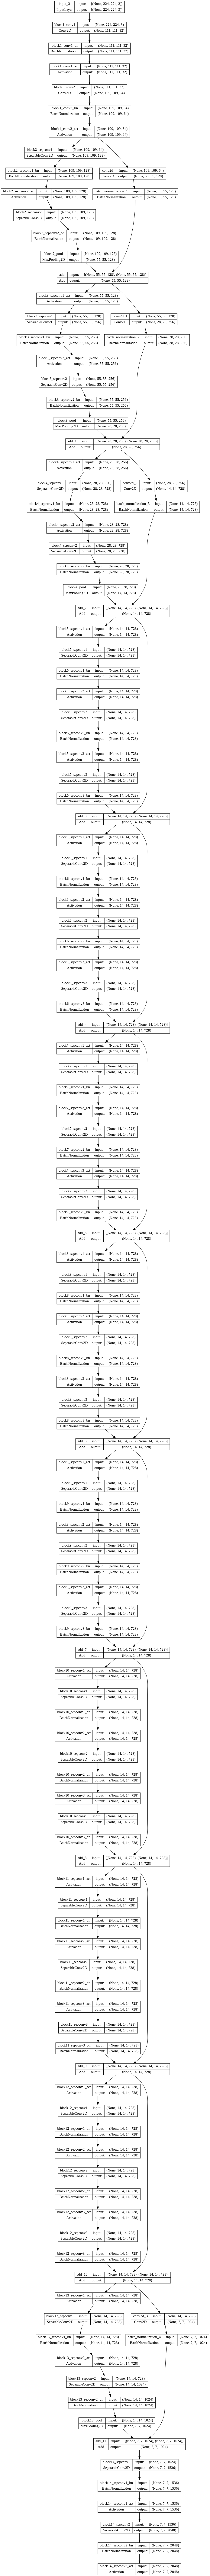

In [40]:
plot_model(ModelXception, show_shapes=True, to_file='ModelXception.png')

**Compile Model**
1.  **Using Adam Optimizer**
2.  **Using ```learning_rate=0.0001```**
3.  **Using ```binary_crossentropy``` as Loss Function**

In [41]:
ModelXception = Model(inputs=ModelXception.input, outputs=outputXception, name="Xception")
ModelXception.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

**Train Model**
1.  **30 Epochs**
2.  **Batch Size of 16** 

Epoch 1/30
165/165 - 60s - loss: 0.4829 - accuracy: 0.7706 - val_loss: 0.4208 - val_accuracy: 0.8182 - 60s/epoch - 366ms/step
Epoch 2/30
165/165 - 52s - loss: 0.3549 - accuracy: 0.8252 - val_loss: 0.3377 - val_accuracy: 0.8576 - 52s/epoch - 316ms/step
Epoch 3/30
165/165 - 52s - loss: 0.2987 - accuracy: 0.8639 - val_loss: 0.3286 - val_accuracy: 0.8697 - 52s/epoch - 313ms/step
Epoch 4/30
165/165 - 52s - loss: 0.2497 - accuracy: 0.8851 - val_loss: 0.3291 - val_accuracy: 0.8758 - 52s/epoch - 314ms/step
Epoch 5/30
165/165 - 52s - loss: 0.2249 - accuracy: 0.9063 - val_loss: 0.3027 - val_accuracy: 0.8758 - 52s/epoch - 314ms/step
Epoch 6/30
165/165 - 52s - loss: 0.1867 - accuracy: 0.9185 - val_loss: 0.3007 - val_accuracy: 0.8545 - 52s/epoch - 313ms/step
Epoch 7/30
165/165 - 52s - loss: 0.1655 - accuracy: 0.9336 - val_loss: 0.3361 - val_accuracy: 0.8591 - 52s/epoch - 314ms/step
Epoch 8/30
165/165 - 52s - loss: 0.1315 - accuracy: 0.9488 - val_loss: 0.4437 - val_accuracy: 0.8394 - 52s/epoch - 313

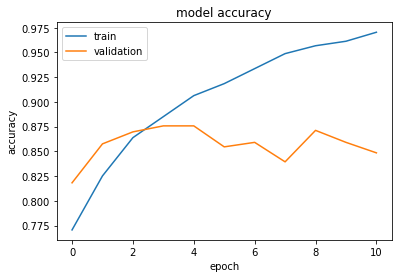

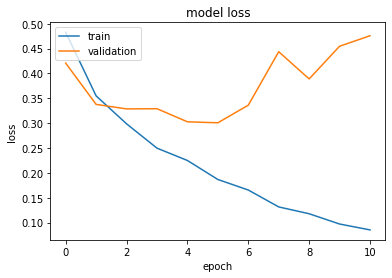

In [42]:
hist = ModelXception.fit(train_ds, epochs=30, validation_data=test_ds, verbose=2, batch_size=16, callbacks=[early_stopping])
plot_hist(hist)

**Saving Model**

In [43]:
ModelXception.save('Xception')

**Copy Model Folder in Your Drive**

In [ ]:
!cp -r "/content/Xception" "/content/drive/MyDrive"

**Evaluate The Model On Training & Test Data Set**

In [44]:
LossXception_train, AccXception_train = ModelXception.evaluate(train_ds)
LossXception_test, AccXception_test = ModelXception.evaluate(test_ds)

print(f'Accuracy Xception on Training Data: {AccXception_train}')
print(f'Accuracy Xception on Test Data: {AccXception_test}')

42/42 [==============================] - 3s 63ms/step - loss: 0.4758 - accuracy: 0.8485
Accuracy Xception on Training Data: 0.9639742374420166
Accuracy Xception on Test Data: 0.8484848737716675


### Create New Dataset Based on Extracted Features

**We Do This For Providing Data For Training Meta Learner Model.**

**We Predict On Both Training And Test Dataset With ```EfficientNetB0```, ```DenseNet121``` & ```Xception``` And Save Them Into ```numpy.ndarray```**

**Try To Load Saved Featured Dataset For Training Data**
****
**If You See ```Featured Dataset is Loaded Successfully! No Need To Create Again!``` Message Means The Featured Dataset Loaded Successfully and No Need To Run The Rest of This Section's Cells!**

**And If You See ```Featured Dataset Loading Failed! You Should Create It Again!``` Message Means Featured Dataset Cannot be Load Because of Missing Featured Dataset File And You Should Create it Again. For This You Should Run Rest of This Section's Cells**

In [ ]:
try:
  FeaturedDataSet = np.load('/content/drive/MyDrive/FeaturedDataset.npy')
  print('Featured Dataset is Loaded Successfully! No Need To Create Again!')
except:
  print('Featured Dataset Loading Failed! You Should Create It Again!')  

Featured Dataset is Loaded Successfully! No Need To Create Again!


**Try To Load Saved Featured Dataset For Test Data**
****
**If You See ```Featured Dataset is Loaded Successfully! No Need To Create Again!``` Message Means The Featured Dataset Loaded Successfully and No Need To Run The Rest of This Section's Cells!**

**And If You See ```Featured Dataset Loading Failed! You Should Create It Again!``` Message Means Featured Dataset Cannot be Load Because of Missing Featured Dataset File And You Should Create it Again. For This You Should Run Rest of This Section's Cells**

In [ ]:
try:
  FeaturedDataSetTest = np.load('/content/drive/MyDrive/FeaturedDatasetTest.npy')
  print('Featured Test Dataset is Loaded Successfully! No Need To Create Again!')
except:
  print('Featured Test Dataset Loading Failed! You Should Create It Again!')

Featured Test Dataset is Loaded Successfully! No Need To Create Again!


**Load Scaled Data Because of Using Its Labels**

In [45]:
train_ds_Unshuffle = train_gen.flow_from_directory('/content/drive/MyDrive/ScaledData/train',target_size=(224, 224),
                                           batch_size=16, shuffle=False)
test_ds_Unshuffle = test_gen.flow_from_directory('/content/drive/MyDrive/ScaledData/test',target_size=(224, 224),
                                         batch_size=16, shuffle=False)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


**Create Training Data For Meta Learner**

**Predict On Training Dataset Using All of Model**

In [46]:
yPredEfficientNetB0 = ModelEfficientNetB0.predict(train_ds_Unshuffle)
yPredDenseNet121 = ModelDenseNet121.predict(train_ds_Unshuffle)
yPredXception = ModelXception.predict(train_ds_Unshuffle)

165/165 [==============================] - 11s 61ms/step


**Concatenate Predicted Scores And Create An ```numpy.ndarray``` with Shape of (2637, 6)**

In [47]:
FeaturedDataSet = np.concatenate([yPredEfficientNetB0, yPredDenseNet121, yPredXception], axis=1)
FeaturedDataSet.shape

(2637, 6)

**Saving Created Dataset into a ```.npy``` File**

In [48]:
np.save('FeaturedDataset.npy', FeaturedDataSet)

**Copy The Dataset File in Your Drive**

In [ ]:
!cp -r "/content/FeaturedDataset.npy" "/content/drive/MyDrive"

**Create Test Data For Meta Learner**

**Predict On Test Dataset Using All of Model**

In [49]:
yPredEfficientNetB0test = ModelEfficientNetB0.predict(test_ds_Unshuffle)
yPredDenseNet121test = ModelDenseNet121.predict(test_ds_Unshuffle)
yPredXceptiontest = ModelXception.predict(test_ds_Unshuffle)

42/42 [==============================] - 3s 60ms/step


**Concatenate Predicted Scores And Create An ```numpy.ndarray``` with Shape of (660, 6)**

In [50]:
FeaturedDataSetTest = np.concatenate([yPredEfficientNetB0test, yPredDenseNet121test, yPredXceptiontest], axis=1)
FeaturedDataSetTest.shape

(660, 6)

**Saving Created Dataset into a ```.npy``` File**

In [51]:
np.save('FeaturedDatasetTest.npy', FeaturedDataSetTest)

**Copy The Test Dataset File in Your Drive**

In [ ]:
!cp -r "/content/FeaturedDatasetTest.npy" "/content/drive/MyDrive"

### Create And Train Meta Learner

**Try To Load Saved ```MetaLearner``` Model**
****
**If You See ```Load Complete! No Need To Train MetaLearner.``` Message Means The MetaLearner Model Loaded Successfully and No Need To Run The Rest of This Section's Cells!**

**And If You See ```Load Failed! You Should Train MetaLearner.``` Message Means Cannot be Load Because of Missing Model Files And You Should Define And Train Model. For This You Should Run Rest of This Section's Cells**

In [ ]:
try:
  MetaLearner = load_model('/content/drive/MyDrive/MetaLearner')
  print('Load Complete! No Need To Train MetaLearner.')
except:
  print('Load Failed! You Should Train MetaLearner.')

Load Complete! No Need To Train MetaLearner.


**Graph The Xception Model**

**Create MetaLearner Model Using 3 Layers:**
1.   **``Dense`` Layer With 8 Neurons & ``relu`` Activation Function**
2.   **``Dense`` Layer With 4 Neurons & ``relu`` Activation Function**
3.   **``Dense`` Layer With 1 Neuron & ``sigmoid`` Activation Function**


In [52]:
MetaLearner = Sequential()
MetaLearner.add(Dense(8, input_dim=6, activation='relu'))
MetaLearner.add(Dense(4, activation='relu'))
MetaLearner.add(Dense(1, activation='sigmoid'))

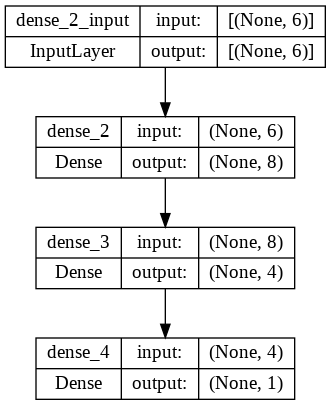

In [53]:
plot_model(MetaLearner, show_shapes=True, to_file='MetaLearner.png')

**Compile Model**
1.  **Using Adam Optimizer**
2.  **Using ```binary_crossentropy``` as Loss Function**

In [54]:
MetaLearner.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

**Train MeteLearner**
1.  **3 Epochs**
2.  **Batch Size of 16** 

Epoch 1/3
165/165 [==============================] - 1s 4ms/step - loss: 0.6629 - accuracy: 0.3724 - val_loss: 0.5584 - val_accuracy: 0.5455
Epoch 2/3
165/165 [==============================] - 1s 3ms/step - loss: 0.4095 - accuracy: 0.8737 - val_loss: 0.4565 - val_accuracy: 0.8485
Epoch 3/3
165/165 [==============================] - 1s 4ms/step - loss: 0.1878 - accuracy: 0.9879 - val_loss: 0.2966 - val_accuracy: 0.8864


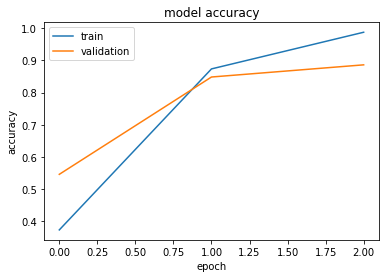

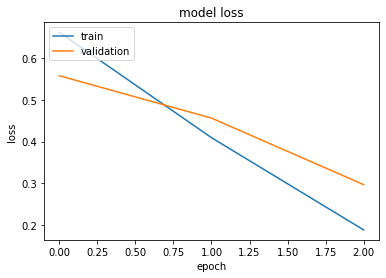

In [55]:
hist = MetaLearner.fit(FeaturedDataSet, train_ds_Unshuffle.labels, epochs=3,
                       validation_data=(FeaturedDataSetTest, test_ds_Unshuffle.labels), verbose=1, batch_size=16)
plot_hist(hist)

**Saving Model**

In [56]:
MetaLearner.save('MetaLearner')

**Copy Model Folder in Your Drive**

In [ ]:
!cp -r "/content/MetaLearner" "/content/drive/MyDrive"

**Evaluate The Model On Training & Test Data Set**

In [57]:
LossMetaLearner_train, AccMetaLearner_train = MetaLearner.evaluate(FeaturedDataSet, train_ds_Unshuffle.labels)
LossMetaLearner_test, AccMetaLearner_test = MetaLearner.evaluate(FeaturedDataSetTest, test_ds_Unshuffle.labels)

print(f'Accuracy MetaLearner on Training Data: {AccMetaLearner_train}')
print(f'Accuracy MetaLearner on Test Data: {AccMetaLearner_test}')

21/21 [==============================] - 0s 2ms/step - loss: 0.2966 - accuracy: 0.8864
Accuracy MetaLearner on Training Data: 0.9958285689353943
Accuracy MetaLearner on Test Data: 0.8863636255264282


### Train VGG16

In [ ]:
try:
  ModelVGG16 = load_model('/content/drive/MyDrive/VGG16')
  print('Load Complete! No Need To Train VGG16.')
except:
  print('Load Failed! You Should Train VGG16.')

Load Complete! No Need To Train VGG16.


In [58]:
ModelVGG16 = vgg16.VGG16(include_top=False, input_shape=(224,224,3), weights="imagenet")
x = Flatten()(ModelVGG16.output)
outputVgg = Dense(2, activation='sigmoid')(x)

ModelVGG16.trainable = True

58889256/58889256 [==============================] - 0s 0us/step


In [59]:
ModelVGG16 = Model(inputs=ModelVGG16.input, outputs=outputVgg, name="VGG16")
ModelVGG16.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

Epoch 1/30
165/165 - 46s - loss: 0.8894 - accuracy: 0.5753 - val_loss: 0.5801 - val_accuracy: 0.6879 - 46s/epoch - 279ms/step
Epoch 2/30
165/165 - 37s - loss: 0.5547 - accuracy: 0.7209 - val_loss: 0.4701 - val_accuracy: 0.7606 - 37s/epoch - 224ms/step
Epoch 3/30
165/165 - 38s - loss: 0.6112 - accuracy: 0.6189 - val_loss: 0.6913 - val_accuracy: 0.5455 - 38s/epoch - 229ms/step
Epoch 4/30
165/165 - 38s - loss: 0.6922 - accuracy: 0.5370 - val_loss: 0.6927 - val_accuracy: 0.5455 - 38s/epoch - 230ms/step
Epoch 5/30
165/165 - 38s - loss: 0.5776 - accuracy: 0.7141 - val_loss: 0.5006 - val_accuracy: 0.7591 - 38s/epoch - 229ms/step
Epoch 6/30
165/165 - 38s - loss: 0.5301 - accuracy: 0.7399 - val_loss: 0.5448 - val_accuracy: 0.7606 - 38s/epoch - 230ms/step
Epoch 7/30
165/165 - 38s - loss: 0.4997 - accuracy: 0.7607 - val_loss: 0.4917 - val_accuracy: 0.7621 - 38s/epoch - 230ms/step
Epoch 7: early stopping


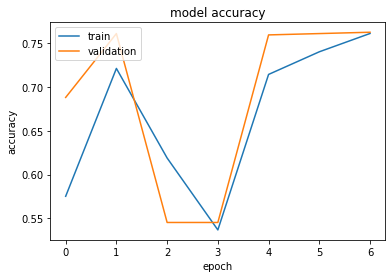

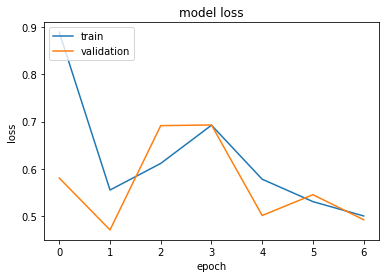

In [60]:
hist = ModelVGG16.fit(train_ds, epochs=30, validation_data=test_ds, verbose=2, batch_size=16, callbacks=[early_stopping])
plot_hist(hist)

In [ ]:
ModelVGG16.save('VGG16')

INFO:tensorflow:Assets written to: VGG16/assets


INFO:tensorflow:Assets written to: VGG16/assets


In [ ]:
!cp -r "/content/VGG16" "/content/drive/MyDrive"

### Train ResNet50

In [ ]:
try:
  ModelResnet50 = load_model('/content/drive/MyDrive/ResNet50')
  print('Load Complete! No Need To Train ResNet50.')
except:
  print('Load Failed! You Should Train ResNet50.')

Load Complete! No Need To Train ResNet50.


In [61]:
ModelResnet50 = resnet50.ResNet50(include_top=False, input_shape=(224,224,3), weights="imagenet")
x = Flatten()(ModelResnet50.output)
outputResnet50 = Dense(2, activation='sigmoid')(x)

ModelResnet50.trainable = True

94765736/94765736 [==============================] - 0s 0us/step


In [62]:
ModelResnet50 = Model(inputs=ModelResnet50.input, outputs=outputResnet50, name="Resnet50")
ModelResnet50.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

Epoch 1/30
165/165 - 41s - loss: 0.8854 - accuracy: 0.7736 - val_loss: 183.5544 - val_accuracy: 0.6848 - 41s/epoch - 248ms/step
Epoch 2/30
165/165 - 32s - loss: 0.3976 - accuracy: 0.8172 - val_loss: 0.3519 - val_accuracy: 0.8394 - 32s/epoch - 195ms/step
Epoch 3/30
165/165 - 32s - loss: 0.3551 - accuracy: 0.8331 - val_loss: 0.3200 - val_accuracy: 0.8621 - 32s/epoch - 192ms/step
Epoch 4/30
165/165 - 32s - loss: 0.4060 - accuracy: 0.8525 - val_loss: 0.3471 - val_accuracy: 0.8348 - 32s/epoch - 193ms/step
Epoch 5/30
165/165 - 32s - loss: 0.3130 - accuracy: 0.8601 - val_loss: 0.3481 - val_accuracy: 0.8333 - 32s/epoch - 193ms/step
Epoch 6/30
165/165 - 32s - loss: 0.2968 - accuracy: 0.8688 - val_loss: 0.3334 - val_accuracy: 0.8455 - 32s/epoch - 193ms/step
Epoch 7/30
165/165 - 32s - loss: 0.3131 - accuracy: 0.8714 - val_loss: 0.4766 - val_accuracy: 0.8258 - 32s/epoch - 194ms/step
Epoch 8/30
165/165 - 32s - loss: 0.3265 - accuracy: 0.8779 - val_loss: 0.6901 - val_accuracy: 0.7455 - 32s/epoch - 1

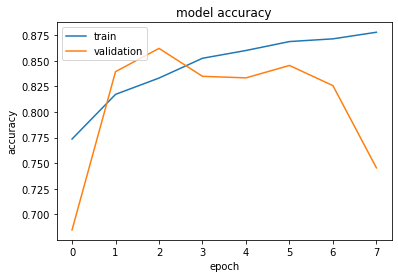

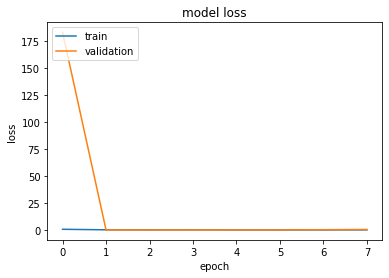

In [63]:
hist = ModelResnet50.fit(train_ds, epochs=30, validation_data=test_ds, verbose=2, batch_size=16, callbacks=[early_stopping])
plot_hist(hist)

In [64]:
ModelResnet50.save('ResNet50')

In [ ]:
!cp -r "/content/ResNet50" "/content/drive/MyDrive"

### Compare All


In [65]:
def PlotROC1(*, Model, Name, X_test, y_test, color):
  y_pred_proba = Model.predict(X_test)
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr,tpr,label=f"Model {Name} auc= %0.3f" %auc, color=color)
  plt.legend(loc=4)

In [66]:
def PlotROC(*, Model, Name, X_test, y_test, color):
  y_pred_proba = Model.predict(X_test)
  y_pred_proba = np.array([np.argmax(x) for x in y_pred_proba])
  fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr,tpr,label=f"Model {Name} ROC = %0.3f" %auc, color=color)
  plt.legend(loc=4)

42/42 [==============================] - 3s 74ms/step


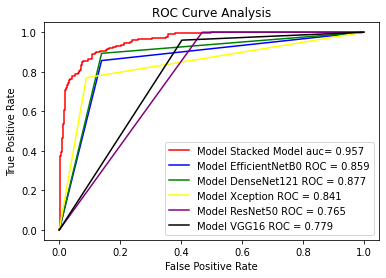

In [67]:
PlotROC1(Model=MetaLearner, X_test=FeaturedDataSetTest, y_test=test_ds_Unshuffle.labels, color='red', Name='Stacked Model')
PlotROC(Model=ModelEfficientNetB0, X_test=test_ds_Unshuffle, y_test=test_ds_Unshuffle.labels, color='blue', Name='EfficientNetB0')
PlotROC(Model=ModelDenseNet121, X_test=test_ds_Unshuffle, y_test=test_ds_Unshuffle.labels, color='green', Name='DenseNet121')
PlotROC(Model=ModelXception, X_test=test_ds_Unshuffle, y_test=test_ds_Unshuffle.labels, color='yellow', Name='Xception')
PlotROC(Model=ModelResnet50, X_test=test_ds_Unshuffle, y_test=test_ds_Unshuffle.labels, color='purple', Name='ResNet50')
PlotROC(Model=ModelVGG16, X_test=test_ds_Unshuffle, y_test=test_ds_Unshuffle.labels, color='black', Name='VGG16')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis')
plt.show()

In [68]:
def specificity_score(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  specificity = tn / (tn+fp)
  return specificity

In [69]:
def MetricsInfo(*, X_test, ModelName, Model):
  print(f'Model {ModelName} Report:\n')
  y_pred_proba = Model.predict(X_test)

  if ModelName == 'MetaLearner':
    y_pred_proba = np.array([1 if x > 0.5 else 0 for x in y_pred_proba])
  else:
    y_pred_proba = np.array([np.argmax(x) for x in y_pred_proba])

  print(f'Accuracy : {round(accuracy_score(test_ds_Unshuffle.labels, y_pred_proba),2)}')
  print(f'F1 Score : {round(f1_score(test_ds_Unshuffle.labels, y_pred_proba),2)}')
  print(f'AUC Score : {round(roc_auc_score(test_ds_Unshuffle.labels, y_pred_proba),2)}')
  print(f'Precision Score : {round(precision_score(test_ds_Unshuffle.labels, y_pred_proba),2)}')
  print(f'Recall Score : {round(recall_score(test_ds_Unshuffle.labels, y_pred_proba),2)}')
  print(f'specificity Score : {round(specificity_score(test_ds_Unshuffle.labels, y_pred_proba),2)}')
  print('-----------------------------------------------------')

In [70]:
MetricsInfo(X_test=FeaturedDataSetTest, ModelName='MetaLearner', Model=MetaLearner)
MetricsInfo(X_test=test_ds_Unshuffle, ModelName='EfficientNetB0', Model=ModelEfficientNetB0)
MetricsInfo(X_test=test_ds_Unshuffle, ModelName='DenseNet121', Model=ModelDenseNet121)
MetricsInfo(X_test=test_ds_Unshuffle, ModelName='Xception', Model=ModelXception)
MetricsInfo(X_test=test_ds_Unshuffle, ModelName='Resnet50', Model=ModelResnet50)
MetricsInfo(X_test=test_ds_Unshuffle, ModelName='VGG16', Model=ModelVGG16)

Model MetaLearner Report:

21/21 [==============================] - 0s 1ms/step
Accuracy : 0.89
F1 Score : 0.87
AUC Score : 0.88
Precision Score : 0.88
Recall Score : 0.86
specificity Score : 0.91
-----------------------------------------------------
Model EfficientNetB0 Report:

42/42 [==============================] - 2s 51ms/step
Accuracy : 0.86
F1 Score : 0.85
AUC Score : 0.86
Precision Score : 0.84
Recall Score : 0.86
specificity Score : 0.86
-----------------------------------------------------
Model DenseNet121 Report:

42/42 [==============================] - 2s 55ms/step
Accuracy : 0.88
F1 Score : 0.87
AUC Score : 0.88
Precision Score : 0.84
Recall Score : 0.89
specificity Score : 0.86
-----------------------------------------------------
Model Xception Report:

42/42 [==============================] - 3s 62ms/step
Accuracy : 0.85
F1 Score : 0.82
AUC Score : 0.84
Precision Score : 0.88
Recall Score : 0.77
specificity Score : 0.91
-----------------------------------------------